In [1]:
# Parameters
symbol = '^GSPC'
start_date = None

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython import display

mpl.rcParams['figure.figsize'] = 8, 6
mpl.rcParams['figure.dpi'] = 100

In [3]:
from tqdm.auto import trange, tqdm

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta

In [5]:
data = yf.Ticker(symbol).history(period='max', auto_adjust=True)[start_date:]

In [6]:
signal = data.Close.pipe(lambda xs: xs.rolling(200).mean().lt(xs)).astype(float)
signal.iloc[:200] = np.nan

In [7]:
signals = pd.concat([signal.rolling(n + 1).mean().rename(n) for n in [30]], axis=1).dropna()

In [8]:
rets = data.Close.div(data.Close.shift()).sub(1).reindex_like(signals)

In [9]:
class Policy(nn.Module):
    def __init__(self, ninputs):
        super(Policy, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(ninputs, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
        )

    def forward(self, x):
        x = self.mlp(x).exp()
        return Beta(x[:, 0], x[:, 1]), Beta(x[:, 2], x[:, 3])
    
    def sample_bounds(self, x, shape=()):
        prob0, prob1 = self.forward(x)
        return torch.stack([
            prob0.rsample(shape), 
            prob1.rsample(shape),
        ], dim=-1).sort(dim=-1).values        

In [19]:
@torch.jit.script
def event_loop(bounds):
    w = torch.zeros_like(bounds[..., 0])
    w0 = torch.zeros_like(w[..., 0])
    for i in range(w.shape[-1]):
        w0 = torch.max(w0, bounds[..., i, 0])
        w0 = torch.min(w0, bounds[..., i, 1])
        w[..., i] = w0
    return w

In [20]:
DEVICE = "cuda"

In [21]:
signals_tensor = torch.tensor(signals.values, device=DEVICE, dtype=torch.float)
rets_tensor = torch.tensor(rets, device=DEVICE, dtype=torch.float)

In [27]:
train_mask = torch.tensor(rets.index > "1970", device=DEVICE)

In [28]:
policy = Policy(signals.shape[1]).float().to(DEVICE)

In [29]:
scaler = torch.cuda.amp.GradScaler()
optimizer = optim.AdamW(policy.parameters(), lr=0.1)

30 - loss.item()=-0.00025213684421032667


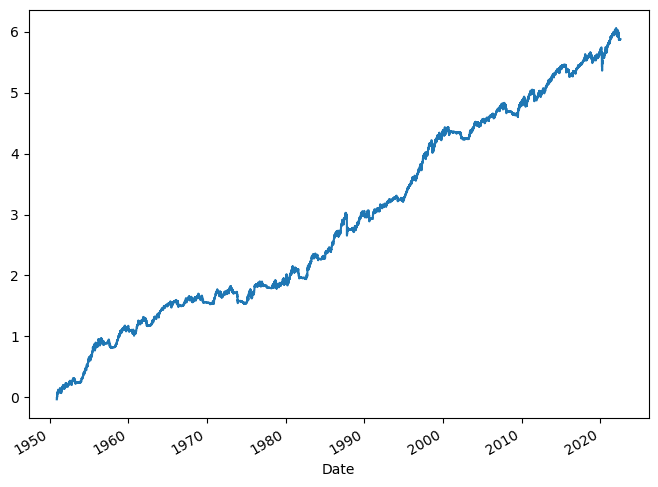

KeyboardInterrupt: 

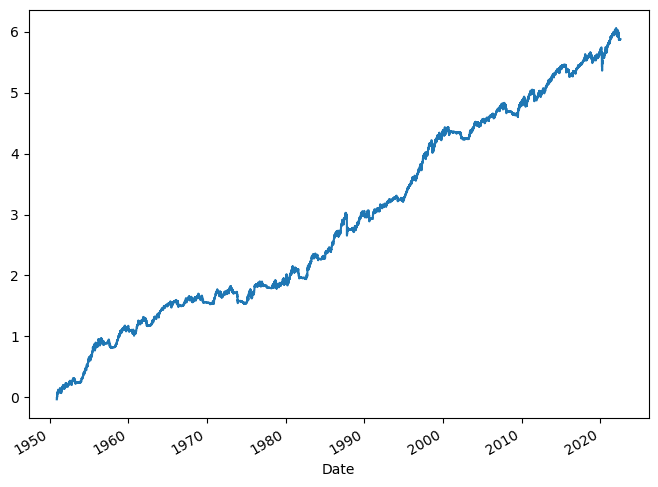

In [30]:
for epoch in trange(1000):
    optimizer.zero_grad()
    
    bounds = policy.sample_bounds(signals_tensor, (100,))
    w = event_loop(bounds)
    gross = w * rets_tensor
    loss = (
        gross[:, train_mask].var(1) -
        gross[:, train_mask].mean(1)
    ).mean()
#     loss += 0.005 * w.diff(dim=1).abs().mean()

    display.clear_output(wait=True)
    tqdm.write(f"{epoch} - {loss.item()=:}")
    plt.close("all")
    pd.Series(gross.mean(0).cpu().detach().numpy(), index=rets.index).cumsum().plot()
    display.display(plt.gcf())

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

In [ ]:
pd.Series(w.cpu().detach(), index=rets.index).plot()